<a href="https://colab.research.google.com/github/yestrella14/DS-Unit-2-Linear-Models/blob/master/LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [3]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [4]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [5]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [6]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])



 Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
 
 Begin with baselines for classification.
 
 Use scikit-learn for logistic regression.
 
 Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
 
 Get your model's test accuracy. (One time, at the end.)
 
 Commit your notebook to your fork of the GitHub repo.




In [7]:
#My code starts here
df.Date[0]

'1/18/2016'

In [8]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].dtype

dtype('<M8[ns]')

In [9]:
df['year'] = pd.to_datetime(df['Date']).dt.to_period('Y')
df[['Date', 'year']].head(2)

,Date,year
0,2016-01-18,2016
1,2016-01-24,2016


In [10]:
df_train = df[(df['year']<='2016')]
print(df_train.shape)
print(df.shape)
df_train.head(2)

(298, 60)
(421, 60)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great,year
0,California,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2016
1,California,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2016


In [11]:
df_validate = df[df['year']=='2017']
print(df_validate.shape)
print(df.shape)
df_validate.head(2)

(85, 60)
(421, 60)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great,year
301,California,2017-01-04,NaN,NaN,NaN,6.6,NaN,NaN,NaN,23.0,20.5,0.77,4.0,4.5,4.0,3.5,3.5,5.0,1.5,3.50,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2017
302,Other,2017-01-04,NaN,NaN,NaN,6.6,NaN,NaN,NaN,20.5,21.5,0.75,4.0,2.0,NaN,4.0,NaN,4.6,4.2,3.75,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2017


In [12]:
test_df= df[df['year']>='2018']
print(test_df.shape)
print(df.shape)
test_df.head(2)

(38, 60)
(421, 60)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great,year
77,California,2026-04-25,NaN,NaN,NaN,8.00,4.0,NaN,NaN,21.59,NaN,NaN,4.5,5.0,5.0,5.0,4.5,5.0,3.0,5.0,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2026
386,California,2018-01-02,NaN,NaN,NaN,7.25,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,5.0,5.0,3.0,3.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2018


In [13]:
#Lets drop the date columns and only leave the Year
df_train = df_train.drop(columns=['Date'])
df_validate = df_validate.drop(columns=['Date'])
test_df = test_df.drop(columns=['Date'])

In [14]:
#Drop the target from the test_df
test_df = test_df.drop(columns=['Great'])

In [15]:
print(df.shape)
print(df_train.shape)
print(df_validate.shape)
print(test_df.shape)
test_df.head(2)

(421, 60)
(298, 59)
(85, 59)
(38, 58)


,Burrito,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,year
77,California,NaN,NaN,NaN,8.00,4.0,NaN,NaN,21.59,NaN,NaN,4.5,5.0,5.0,5.0,4.5,5.0,3.0,5.0,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2026
386,California,NaN,NaN,NaN,7.25,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,5.0,5.0,3.0,3.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018


 
**Begin with baselines for classification.**
 
 

In [16]:
# how many people in our training dataset actually survived the voyage?
target = 'Great'
y_train = df_train[target]
y_train.value_counts(normalize=True)

False    0.590604
True     0.409396
Name: Great, dtype: float64

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


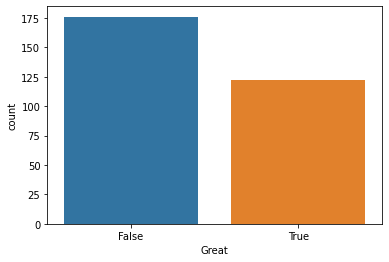

In [17]:
import seaborn as sns
sns.countplot(y_train);

In [18]:
#Whats the most frequent value
majority_class = y_train.mode()
majority_class

0    False
dtype: bool

In [19]:
#List of zeros the size of the df
y_pred = [majority_class]* len(y_train)
print(y_train.shape)
len(y_pred)

(298,)


298

In [20]:
from sklearn.metrics import accuracy_score
print('Training accuracy of majority class baseline')
print(accuracy_score(y_train, y_pred))

print('\nValidation accuracy of majority class baseline')
y_val= df_validate[target]
y_Vpred = [majority_class]*len(y_val)
print(accuracy_score(y_val, y_Vpred))


Training accuracy of majority class baseline
0.5906040268456376

Validation accuracy of majority class baseline
0.5529411764705883


**Use scikit-learn for logistic regression.**

In [21]:
df.columns
features = ['Tortilla', 'Temp', 'Meat', 'Salsa', 'Guac', 'Pico']
target='Great'

X_Train = df_train[features]
y_train= df_train[target]
X_val = df_validate[features]
y_val = df_validate[target]

X_Train.shape, y_train.shape, X_val.shape, y_val.shape

((298, 6), (298,), (85, 6), (85,))

In [22]:
print(X_Train.isnull().sum())
print(X_val.isnull().sum())

Tortilla      0
Temp         15
Meat         10
Salsa        20
Guac        159
Pico        155
dtype: int64
Tortilla     0
Temp         5
Meat         2
Salsa        2
Guac        78
Pico        77
dtype: int64


In [23]:
print(X_Train['Temp'].value_counts(ascending=False).head(1))
# X_Train['Temp'].fillna(4.0, inplace=True)
print(X_Train['Meat'].value_counts(ascending=False).head(1))
# X_Train['Meat'].fillna(4.0, inplace=True)
print(X_Train['Salsa'].value_counts(ascending=False).head(1))
# X_Train['Salsa'].fillna(3.0, inplace=True)
print(X_Train['Guac'].value_counts(ascending=False).head(1))
# X_Train['Guac'].fillna('x', inplace=True)
print(X_Train['Pico'].value_counts(ascending=False).head(2))
# X_Train['Pico'].fillna('x', inplace=True)

4.0    70
Name: Temp, dtype: int64
4.0    81
Name: Meat, dtype: int64
3.0    58
Name: Salsa, dtype: int64
x    101
Name: Guac, dtype: int64
x    115
X     28
Name: Pico, dtype: int64


In [24]:
print(X_Train.isnull().sum())
print(X_val.isnull().sum())

Tortilla      0
Temp         15
Meat         10
Salsa        20
Guac        159
Pico        155
dtype: int64
Tortilla     0
Temp         5
Meat         2
Salsa        2
Guac        78
Pico        77
dtype: int64


In [25]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

In [26]:
X_Train.describe(include='all')

,Tortilla,Temp,Meat,Salsa,Guac,Pico
count,298.000000,283.000000,288.000000,278.000000,139,143
unique,NaN,NaN,NaN,NaN,2,2
top,NaN,NaN,NaN,NaN,x,x
freq,NaN,NaN,NaN,NaN,101,115
mean,3.472315,3.706360,3.551215,3.324640,NaN,NaN
std,0.797606,0.991897,0.869483,0.971226,NaN,NaN
min,1.400000,1.000000,1.000000,0.000000,NaN,NaN
25%,3.000000,3.000000,3.000000,2.500000,NaN,NaN
50%,3.500000,4.000000,3.500000,3.500000,NaN,NaN
75%,4.000000,4.500000,4.000000,4.000000,NaN,NaN


In [27]:
#Convert categorical values
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_Train)

X_val_encoded = encoder.fit_transform(X_val)

In [28]:
print(X_train_encoded.head(2))
X_train_encoded.isnull().sum()

   Tortilla  Temp  Meat  Salsa  ...  Guac_X  Pico_x  Pico_nan  Pico_X
0       3.0   5.0   3.0    4.0  ...       0       1         0       0
1       2.0   3.5   2.5    3.5  ...       0       1         0       0

[2 rows x 10 columns]


Tortilla     0
Temp        15
Meat        10
Salsa       20
Guac_x       0
Guac_nan     0
Guac_X       0
Pico_x       0
Pico_nan     0
Pico_X       0
dtype: int64

In [29]:
#lets input the missing data with the mean

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)

In [30]:
#Do the same to Validation but do not fit it
X_val_imputed = imputer.transform(X_val_encoded)

#Scale the data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)

#same to the validation data only traqnsform
X_val_scaled = scaler.transform(X_val_imputed)

In [31]:
pd.DataFrame(X_val_scaled).head()

,0,1,2,3,4,5,6,7,8,9
0,0.662698,0.822508,5.259498e-01,-1.948611,1.396601,-1.069526,-0.382301,1.261469,-1.041113,-0.322031
1,0.662698,-1.768429,-5.204469e-16,0.934834,1.396601,-1.069526,-0.382301,1.261469,-1.041113,-0.322031
2,-0.593162,0.822508,6.431440e-01,1.041628,1.396601,-1.069526,-0.382301,1.261469,-1.041113,-0.322031
3,0.034768,0.304321,5.259498e-01,0.721245,1.396601,-1.069526,-0.382301,1.261469,-1.041113,-0.322031
4,-1.221093,0.822508,-6.459925e-01,-1.414639,1.396601,-1.069526,-0.382301,1.261469,-1.041113,-0.322031


In [32]:
#Fit the model using the transformed training dataset
model = LogisticRegressionCV()
model.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [33]:
#Make predictions
y_pred = model.predict(X_val_scaled)

In [34]:
#Validation Accuracy
print('validation Accuracy: ', accuracy_score(y_val, y_pred))

validation Accuracy:  0.788235294117647


In [35]:
coefficients = pd.DataFrame(model.coef_[0], X_train_encoded.columns, columns=['probabilities'])
print(coefficients)

          probabilities
Tortilla       0.641584
Temp           0.469464
Meat           1.545594
Salsa          0.571020
Guac_x         0.358517
Guac_nan      -0.190677
Guac_X        -0.223590
Pico_x        -0.201505
Pico_nan       0.252125
Pico_X        -0.095506


          probabilities  odd_ratios
Tortilla       0.641584    1.899487
Temp           0.469464    1.599138
Meat           1.545594    4.690756
Salsa          0.571020    1.770072
Guac_x         0.358517    1.431206
Guac_nan      -0.190677    0.826399
Guac_X        -0.223590    0.799643
Pico_x        -0.201505    0.817499
Pico_nan       0.252125    1.286757
Pico_X        -0.095506    0.908913


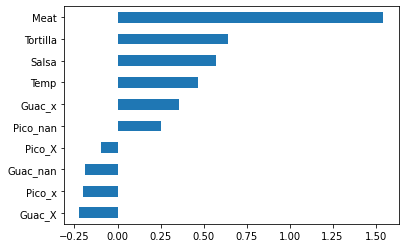

In [39]:
import numpy as np
odds_ratios = np.exp(model.coef_)
coefficients['odd_ratios']= odds_ratios[0]
print(coefficients)
coefficients= pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients.sort_values().plot.barh();



Get your model's validation accuracy. (Multiple times if you try multiple iterations.)

Get your model's test accuracy. (One time, at the end.)

Commit your notebook to your fork of the GitHub repo.